# [NTDS'18] Team project
[ntds'18]: https://github.com/mdeff/ntds_2018

## Students

* Team: `<34>`
* Students: `<Valentin Morel, Xavier Sieber, Cédric Schumacher, Charles-Théophile Coen>`
* Dataset: `<Terrorist attack>`

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from pyunlocbox import functions, solvers
from scipy.optimize import minimize as opt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.datasets import make_blobs
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score, auc, mean_squared_error, mean_absolute_error, roc_curve, median_absolute_error, roc_auc_score,f1_score
from sklearn import preprocessing
from sklearn.model_selection import KFold, validation_curve, train_test_split
from sklearn.metrics import confusion_matrix 
import itertools
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import warnings
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier

## Section 0.0
This section consists of creating or loading the different objects that we need for further tasks.

In [2]:
# Features
features = pd.read_csv('TerrorAttack/terrorist_attack.nodes',delim_whitespace=' ',header = None,engine='python')
features = features.drop( columns=0)
features = features.drop(columns=107)
features = features.values

# Labels
labels = pd.read_csv('TerrorAttack/terrorist_attack.nodes',delim_whitespace=' ',header = None,engine='python')[[107]]
labels[107] = labels[107].map(lambda x: x.lstrip('http://counterterror.mindswap.org2005/ict_events.owl#'))
labels = labels.values

# Locations
adjacency_location = np.load('adjacency_location.npy')
adjacency_location[881][967] = 1
adjacency_location[967][881] = 1
adjacency_location[582][587] = 1
adjacency_location[587][582] = 1
n_nodes = len(adjacency_location)

location = np.zeros(n_nodes)
number_loc = 0
location[0] = number_loc
index = []
for i in range(0,n_nodes):
    #if i != 0:
    if not location[i] in location[0:i]:
        number_loc += 1
        location[i] = number_loc
    else:
        index.append(i)

    if not location[i] in location[0:i]:
        for j in range(i,n_nodes):
            if adjacency_location[i,j] == 1:
                location[j] = location[i]

# Index of locations with one (index_loc_alnoe) or more than one (index_loc_more) attack
index_loc_alone = []
index_loc_more = []
for i in range(1293):
    if np.amax(adjacency_location[i,:]) < 1:
        index_loc_alone.append(i)
    else:
        index_loc_more.append(i)

## Section 0.1
This section is dedicated to the different functions used troughout this whole project.

In [3]:
def clustering_location (features,Ltype,k,typ,gt,plot):
    """
    The features are a NxM matrix with N nodes and M features per nodes. This function creates
    an adjacency matrix and computes its Laplacian. Three types of Laplacian can be computed 
    trough "Ltype". 
    
    "K" is the number of cluster wanted and "typ" is the clustering algorithm chosen. Four possibilities:
    sc: Spectral clustering
    bi: Birch clustering
    hd: HDBscan clustering
    km: KMeans clustering
    
    gt is the ground truth and plot is a variable set to 1 if a plot comparing the ground truth and the
    cluster assignement is wanted.
    
    """
    
    
    # Creating adjacency
    distances = pdist(features, metric='euclidean')
    kernel_width = distances.mean()
    weights = np.exp(-distances**2 / kernel_width**2)
    adjacency = squareform(weights)
    
    # Creation of the Laplacian 
    degree=adjacency.sum(axis=0)
    adjacency = sparse.csr_matrix(adjacency)
    
    D = sparse.diags(degree)
    D_rw=sparse.diags(1/degree)
    D_n = sparse.diags(1/np.sqrt(degree))
    L = D - adjacency
    L_rw = D_rw.dot(L)
    L_n = D_n.dot(L.dot(D_n))
    
    if Ltype=='std':
        Lap=L
    if Ltype=='rw':
        Lap=L_rw
    if Ltype=='norm':
        Lap=L_n
    
    # Spectral decomposition
    e, U = np.linalg.eigh(Lap.A)
    
    # Clustering
    if typ == 'sc':
        my_clust = SpectralClustering(k, affinity='precomputed')
        my_clust = my_clust.fit_predict(adjacency.A)
    if typ == 'bi':
        my_clust = Birch(threshold= 0.9, n_clusters = k)
        my_clust = my_clust.fit_predict(features)
    if typ == 'hd':
        my_clust = hdbscan.HDBSCAN(min_cluster_size=k)
        my_clust = my_clust.fit_predict(features)
    if typ == 'km':
        my_clust = KMeans(k)
        my_clust = my_clust.fit_predict(features)
    
    # Plotting of the data with ground truth and the clustering attribution
    if plot:
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(121,projection='3d')
        ax1.scatter(U[:,1],U[:,2],U[:,3],c=gt,cmap='rainbow')
        ax1.set_title('Laplacian eigenmap with ground truth.')
        ax1.set_xlabel('First eigenvector')
        ax1.set_ylabel('Second eigenvector')
        ax1.set_zlabel('Third eigenvector')
        ax1.xaxis.labelpad=10
        ax1.yaxis.labelpad=15
        ax1.zaxis.labelpad=20
        
        ax2 = fig.add_subplot(122,projection='3d')
        ax2.scatter(U[:,1],U[:,2],U[:,3],c=my_clust,cmap='rainbow')
        ax2.set_title('Laplacian eigenmap with cluster assignement.')
        ax2.set_xlabel('First eigenvector')
        ax2.set_ylabel('Second eigenvector')
        ax2.set_zlabel('Third eigenvector')
        ax2.xaxis.labelpad=10
        ax2.yaxis.labelpad=15
        ax2.zaxis.labelpad=20
        
        plt.rcParams.update({'font.size': 12})
        plt.savefig('cluster_loc.png',bbox_inches = 'tight')
        plt.show()
    
    return my_clust

def clustering_label(feature,kernel,gt,Ltype,k,typ,plot):
    
    """
    The features are a NxM matrix with N nodes and M features per nodes. This function creates
    an adjacency matrix and computes its Laplacian. Three types of Laplacian can be computed 
    trough "Ltype".     
    "kernel" is the metric used to compute the distance between the features of two different nodes. 
    This distance is used to create the weighted adjacency matrix.
    
    "K" is the number of cluster wanted and "typ" is the clustering algorithm chosen. Four possibilities:
    sc: Spectral clustering
    bi: Birch clustering
    hd: HDBscan clustering
    km: KMeans clustering
    
    gt is the ground truth and plot is a variable set to 1 if a plot comparing the ground truth and the
    cluster assignement is wanted.
    
    """
    
    # Creating adjacency
    distances = pdist(feature, metric=kernel)
    kernel_width = distances.mean()
    weights = np.exp(-distances**2 / kernel_width**2)
    adjacency = squareform(weights)
    
    # Creation of the Laplacian 
    degree=adjacency.sum(axis=0)
    adjacency = sparse.csr_matrix(adjacency)
    
    D = sparse.diags(degree)
    D_rw=sparse.diags(1/degree)
    D_n = sparse.diags(1/np.sqrt(degree))
    L = D - adjacency
    L_rw = D_rw.dot(L)
    L_n = D_n.dot(L.dot(D_n))
    
    if Ltype=='std':
        Lap=L
    if Ltype=='rw':
        Lap=L_rw
    if Ltype=='norm':
        Lap=L_n
    
    # Spectral decomposition
    e, U = np.linalg.eigh(Lap.A)
    
    # Clustering
    if typ == 'sc':
        my_clust = SpectralClustering(k, affinity='precomputed')
        my_clust = my_clust.fit_predict(adjacency.A)
    if typ == 'bi':
        my_clust = Birch(threshold= 0.8, n_clusters = k)
        my_clust = my_clust.fit_predict(feature)
    if typ == 'hd':
        my_clust = hdbscan.HDBSCAN(min_cluster_size=k)
        my_clust = my_clust.fit_predict(feature)
    if typ == 'km':
        my_clust = KMeans(k)
        my_clust = my_clust.fit_predict(feature)
    
    if plot:
        fig = plt.figure(figsize=(16,10))
        
        ax1 = fig.add_subplot(121,projection='3d')
        ax1.scatter(U[:,1],U[:,2],U[:,3],c=gt)#,cmap='rainbow')
        ax1.set_title('Laplacian eigenmap with ground truth.')
        ax1.set_xlabel('First eigenvector')
        ax1.set_ylabel('Second eigenvector')
        ax1.set_zlabel('Third eigenvector')
        ax1.xaxis.labelpad=10
        ax1.yaxis.labelpad=15
        ax1.zaxis.labelpad=20
        
        ax2 = fig.add_subplot(122,projection='3d')
        ax2.scatter(U[:,1],U[:,2],U[:,3],c=my_clust,cmap='rainbow')
        ax2.set_title('Laplacian eigenmap with cluster assignement.')
        ax2.set_xlabel('First eigenvector')
        ax2.set_ylabel('Second eigenvector')
        ax2.set_zlabel('Third eigenvector')
        ax2.xaxis.labelpad=10
        ax2.yaxis.labelpad=15
        ax2.zaxis.labelpad=20
        
        plt.rcParams.update({'font.size': 12})
        plt.savefig('cluster_label.png',bbox_inches = 'tight')
        plt.show()
    
    return my_clust

def costLS (x,f,gt):
    
    """
    computes ||f dot x - gt||
    
    """
    f_=f.astype(float)
    gt_=gt.astype(float)
    cost=0
    length=f_.shape[0]
    x=x.reshape((106,6))
    
    if f_.shape[0] != gt_.shape[0]:
        exit('Dim missmatch')
    for i in range(0,length):
        #print(np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:]))
        tmp=np.linalg.norm(np.dot(f_[i,:],x)-gt_[i,:])
        cost += tmp
    
    #print(cost)
    return cost

def gradLS(x,f,gt):
    
    """
    computes 2(f dot x - gt)f
    
    """
    
    f_=f.astype(float)
    gt_=gt.astype(float)
    grad = np.zeros((106,6))
    
    for i in range (0,1293):
        er=np.dot(f_[i,:],x)-gt_[i,:]
        dif=f_[i,:]
        dif = dif.reshape((106,1))
        grad += 2*dif*er
    grad = grad/1293
    return grad

def grad_descent (x0,f,gt,niter,gam,verbose):
    
    """
    iterates {x_k+1 = x_k -  gam \nabla x_k}    niter times starting at x0
    
    """
    
    tmp=x0
    for i in range (0,niter):
        x_p=tmp-gam*gradLS(tmp,f,gt)
        tmp=x_p
        #if i%verbose==0:
        #    print(costLS(x_p,f,gt))
    return x_p

## Section 1.0
In this project, each attack has 106 features and two types of labels: a location, and a type of attack. This part consists of doing basic analysis of these two labels for each node.

Features [3, 15, 19, 35, 56, 69] have a correlation greater than 95 percentage with other features and could be discarded.


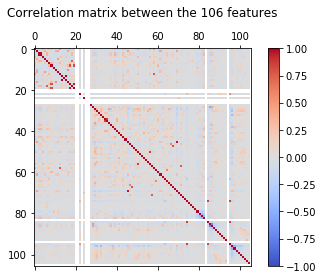

In [4]:
# Corelation of the features
features_panda = pd.DataFrame(features)
corr_matrix = features_panda.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print('Features %s have a correlation greater than 95 percentage with other features and could be discarded.' %(to_drop))

corr = features_panda.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
plt.title('Correlation matrix between the 106 features\n')
plt.rcParams.update({'font.size': 12})
plt.savefig('correlation.png',bbox_inches = 'tight')
plt.show()

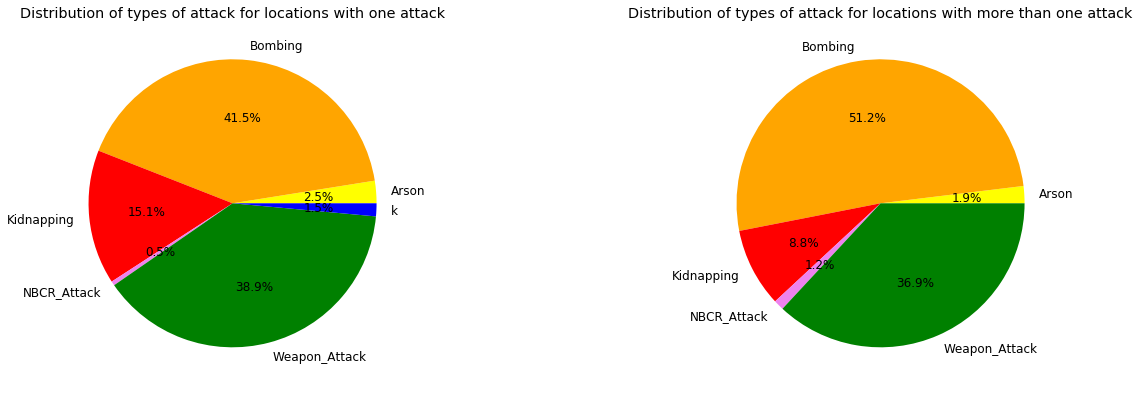

In [5]:
y_single_attack = np.take(labels,index_loc_alone)
y_multiple_attack = np.take(labels,index_loc_more)

ele_single_attack, counts_sing_attack = np.unique(y_single_attack, return_counts = True)
ele_multiple_attack, counts_multiple_attack = np.unique(y_multiple_attack, return_counts = True)

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(counts_sing_attack,labels=ele_single_attack,autopct='%1.1f%%',colors=['yellow','orange', 'red', 'violet','green', 'blue'])
ax1.set_title('Distribution of types of attack for locations with one attack')

ax2 = fig.add_axes([0.5, 0, .5, .5], aspect=1)
ax2.pie(counts_multiple_attack,labels=ele_multiple_attack,autopct='%1.1f%%',colors=['yellow','orange', 'red', 'violet','green', 'blue'])
ax2.set_title('Distribution of types of attack for locations with more than one attack')
plt.rcParams.update({'font.size': 15})
plt.savefig('distribution.png',bbox_inches = 'tight')
plt.show()

##### **Remarks**
The first remark is that the features given are good features. Indeed, only 6 of them have a correlation greater than 0.85. These four features could be discarded, but we decided to keep all the features for this project.

Secondly, the distributions of types of attack is shown above. Two distributions are made: one for locations with only one attack and one for locations with more than one attack. The distribution is roughly the same: the main categories are the same and in the same order.

## Section 2.0
In this section, only the locations with more than one attack are chosen. The goal is try to predict if an attack is collocated with another one, only by looking at the features. In order to do so, four different clustering algorithm are tested: Birch, HDBscan, KMeans and Spectral Clustering. The metric used to compare the different algorithm is the Adjusted Mutual Information (AMI). The maximum score of AMI is 1, meaning a perfect clustering; this metric is more thoroughly explained in the report. 

In [6]:
# Creation of an adjacency matrix only with locations with more than one attack
adj = adjacency_location
ind = np.array(index_loc_alone)
for i in range(0,len(index_loc_alone)):
    adj = np.delete(adj,ind[i],0)
    adj = np.delete(adj, ind[i],1)
    ind = ind -1 

typ_clust = ['bi','hd','km','sc']
typ_print = ['Birch', 'HDBscan','KMeans','Spectral Clustering']
n = 0
for i in typ_clust:
    clus = clustering_location(features[index_loc_more],'norm',79,i,location[index_loc_more],0)
    met = metrics.adjusted_mutual_info_score(clus,location[index_loc_more])
    print('For clustering type %s, AMI metric of: %f' %(typ_print[n],met))
    n+=1

For clustering type Birch, AMI metric of: 0.323499
For clustering type HDBscan, AMI metric of: -0.000000
For clustering type KMeans, AMI metric of: 0.298200
For clustering type Spectral Clustering, AMI metric of: 0.274801


##### **Remarks**
The best clustering is achieved by using Birch clustering. The AMI metric gives a result of 0.32 out of 1, which is quite low. This means that the features cannot be used in order to predict if an attack is collocated with another one. 

Below, the ground truth, on the left, as well as the cluster assignement using the Birch algorithm, on the right, are plotted on the data using the Laplacian eigenmaps, in order to embed the information in 3D.

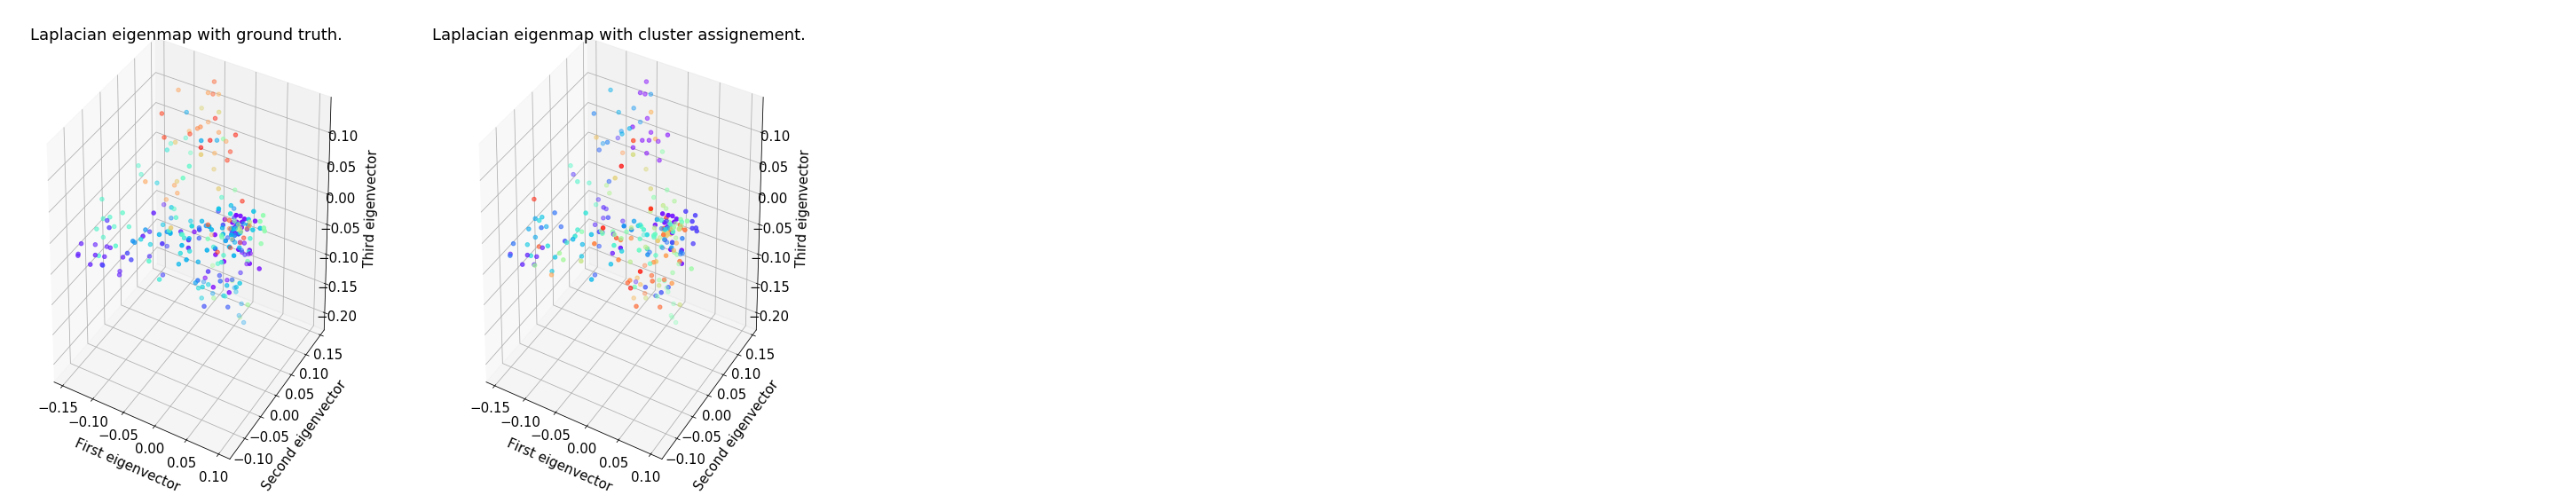

In [7]:
c = clustering_location(features[index_loc_more],'norm',79,'bi',location[index_loc_more],1)

## Section 3.0
The goal of this section is to use the features in order to find the type of attack for each node. The first part is dedicated to a network approach, where different clustering algorithm are used in order to determine the different type of attack. As it is shown after, this approach does not yield good results. Therefore, a hybrid approach, mixing maching learning and network analysis, is tested to see if better results can be obtained. 

Finally, a pure machine learning approach is explored and different classifiers are created.

#### Section 3.1: The network approach
This subsection explores the possibility to cluster the data in different types of attack by using the given features for every attacks. Four different type of clustering are tested: Birch, HDBscan, KMeans and Spectral Clustering. Moreover, two different type of distances are used: euclidean or cosine. This distance is used for the formation of the adjacency matrix. The goal is to test if different types of distance greatly influence the result or not. Finally, the number of cluster is chosen between 3 or 6. The real number of cluster is 6, but as they are heavily dissproportionate (large number of attacks in some categories like bombing, kidnapping or weapon attack compared to other type of attack), the idea is to only define 3 clusters to see if it yields better results. 

In [8]:
mydic = {'Arson':1, 'Bombing':2, 'Kidnapping':3, 'NBCR_Attack':4, 'Weapon_Attack':5, 'k':6}
gt = (pd.DataFrame(labels).replace(mydic)).values

typ_clust = ['bi','hd','km','sc']
typ_dist = ['euclidean','cosine']
nb_clust = [3,6]
typ_print = ['Birch', 'HDBscan','KMeans','Spectral Clustering']
n = 0
for i in typ_clust:
    for j in typ_dist:
        for k in nb_clust:
            clus = clustering_label(features,j,gt,'norm',k,i,0)
            met = metrics.adjusted_mutual_info_score(np.reshape(gt,len(gt)),clus)
            print('For clustering type %s, with %s distance and %i clusters, AMI metric of: %f' %(typ_print[n],j,k,met))
    n+=1

For clustering type Birch, with euclidean distance and 3 clusters, AMI metric of: 0.238392
For clustering type Birch, with euclidean distance and 6 clusters, AMI metric of: 0.256206
For clustering type Birch, with cosine distance and 3 clusters, AMI metric of: 0.238392
For clustering type Birch, with cosine distance and 6 clusters, AMI metric of: 0.256206
For clustering type HDBscan, with euclidean distance and 3 clusters, AMI metric of: 0.144936
For clustering type HDBscan, with euclidean distance and 6 clusters, AMI metric of: 0.126331
For clustering type HDBscan, with cosine distance and 3 clusters, AMI metric of: 0.144936
For clustering type HDBscan, with cosine distance and 6 clusters, AMI metric of: 0.126331
For clustering type KMeans, with euclidean distance and 3 clusters, AMI metric of: 0.238753
For clustering type KMeans, with euclidean distance and 6 clusters, AMI metric of: 0.228066
For clustering type KMeans, with cosine distance and 3 clusters, AMI metric of: 0.236255
For

##### **Remarks**
Obviously, the results obtained by the different clustering methods are not satisfying. The maximum AMI score obtained is around 0.26 out of 1 by using the Spectral Clustering algorithm with 3 clusters. However, this result is not that suprising. Indeed, the main problem comes from the fact that the features are hard to separate, in any possible projections. To illustrate this, the ground truth is plotted on the Laplacian eigenmap below on the left. Normally, the Laplacian eigenmap is one of the best projections possible, but in the figure below, we clearly see that the labels, i.e. the types of attack, are mixed with each other. On the right, we plotted the clustering assignement for Spectral Clustering, with euclidean distance and only 3 clusters.

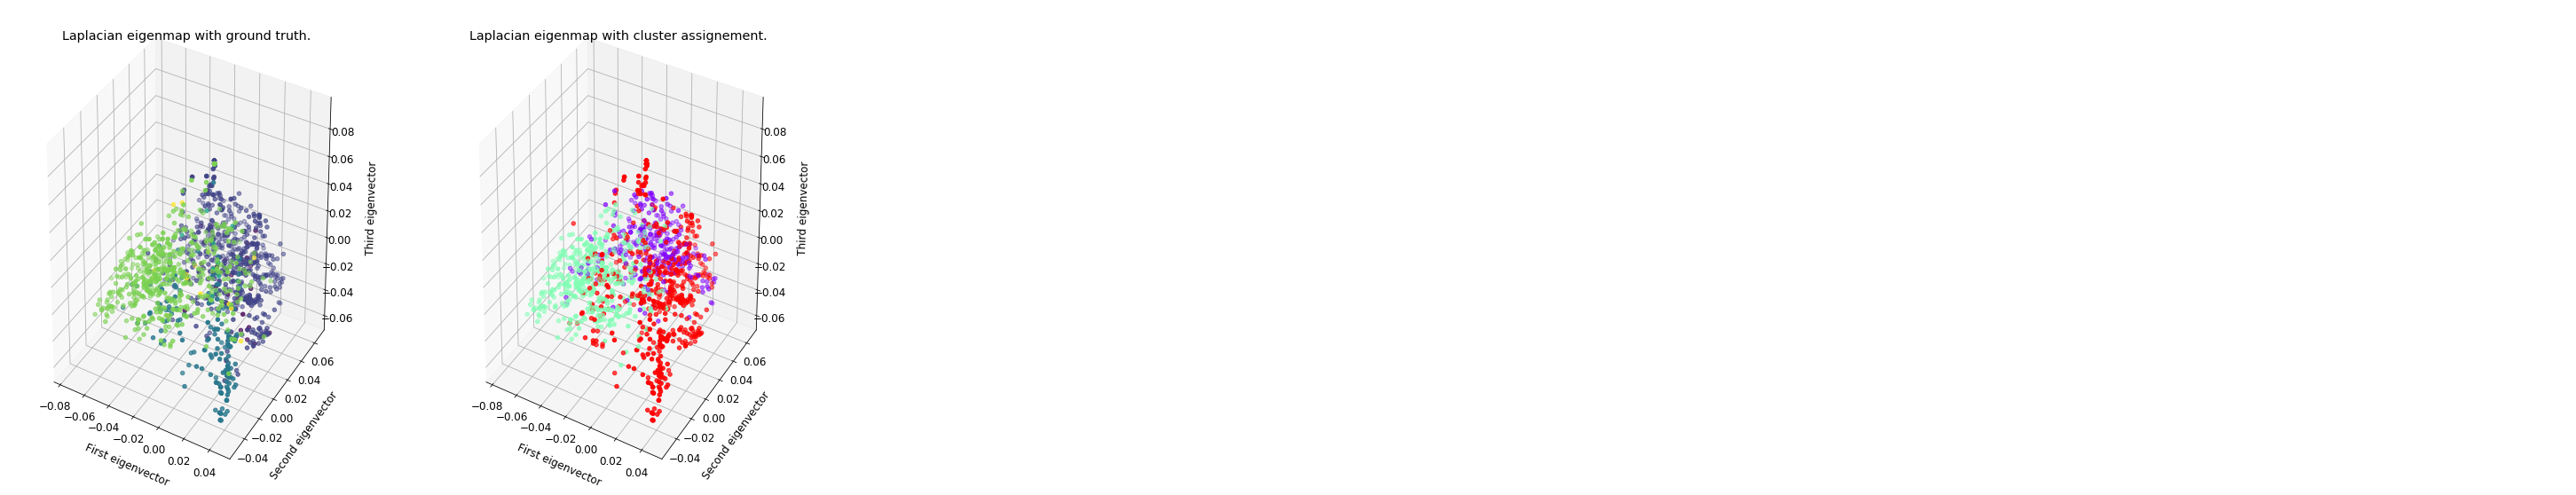

In [9]:
c = clustering_label(features,'euclidean',np.reshape(gt,len(gt)),'norm',3,'bi',1)

#### Section 3.2: The hybrid approach
As seen in the previous section, regardless of the clustering algorithm used, the results obtained are not good. It is mainly due to the fact that the features cannot be used to correctly cluster the different types of attack. The idea in this section is to first project the features in a better dimension. Do to so, the difference between the projected features, and the known type of attack should be minimized. Much informations are given in the report. 

In [10]:
%%time
mydic2 = {'Arson':np.array([[1,0,0,0,0,0]]), 'Bombing':np.array([[0,1,0,0,0,0]]), 'Kidnapping':np.array([[0,0,1,0,0,0]]), 'NBCR_Attack':np.array([[0,0,0,1,0,0]]), 'Weapon_Attack':np.array([[0,0,0,0,1,0]]), 'k':np.array([[0,0,0,0,0,1]])}

gt2 = mydic2[labels[0][0]]
for i in range (1,len(labels)):
    gt2 = np.vstack((gt2,mydic2[labels[i][0]]))

x0 = np.zeros((106,6))
projection_matrix = grad_descent(x0,features,gt2,10000,0.1,100)

CPU times: user 4min 3s, sys: 873 ms, total: 4min 4s
Wall time: 4min 6s


In [11]:
typ_clust = ['bi','hd','km','sc']
typ_dist = ['euclidean','cosine']
nb_clust = [3,6]
typ_print = ['Birch', 'HDBscan','KMeans','Spectral Clustering']
n = 0
for i in typ_clust:
    for j in typ_dist:
        for k in nb_clust:
            clus = clustering_label(np.dot(features,projection_matrix),j,gt,'norm',k,i,0)
            met = metrics.adjusted_mutual_info_score(np.reshape(gt,len(gt)),clus)
            print('For clustering type %s, with %s distance and %i clusters, AMI metric of: %f' %(typ_print[n],j,k,met))
    n+=1

For clustering type Birch, with euclidean distance and 3 clusters, AMI metric of: -0.000000
For clustering type Birch, with euclidean distance and 6 clusters, AMI metric of: -0.000000
For clustering type Birch, with cosine distance and 3 clusters, AMI metric of: -0.000000
For clustering type Birch, with cosine distance and 6 clusters, AMI metric of: -0.000000
For clustering type HDBscan, with euclidean distance and 3 clusters, AMI metric of: 0.200606
For clustering type HDBscan, with euclidean distance and 6 clusters, AMI metric of: 0.339243
For clustering type HDBscan, with cosine distance and 3 clusters, AMI metric of: 0.200606
For clustering type HDBscan, with cosine distance and 6 clusters, AMI metric of: 0.339243
For clustering type KMeans, with euclidean distance and 3 clusters, AMI metric of: 0.530323
For clustering type KMeans, with euclidean distance and 6 clusters, AMI metric of: 0.430983
For clustering type KMeans, with cosine distance and 3 clusters, AMI metric of: 0.530323

##### **Remarks**
The score are better compared to before. It shows that by projecting our features in a better dimension, better clustering is achieved. The result for spectral clustering is shown below for a cosine distance with 6 clusters. 

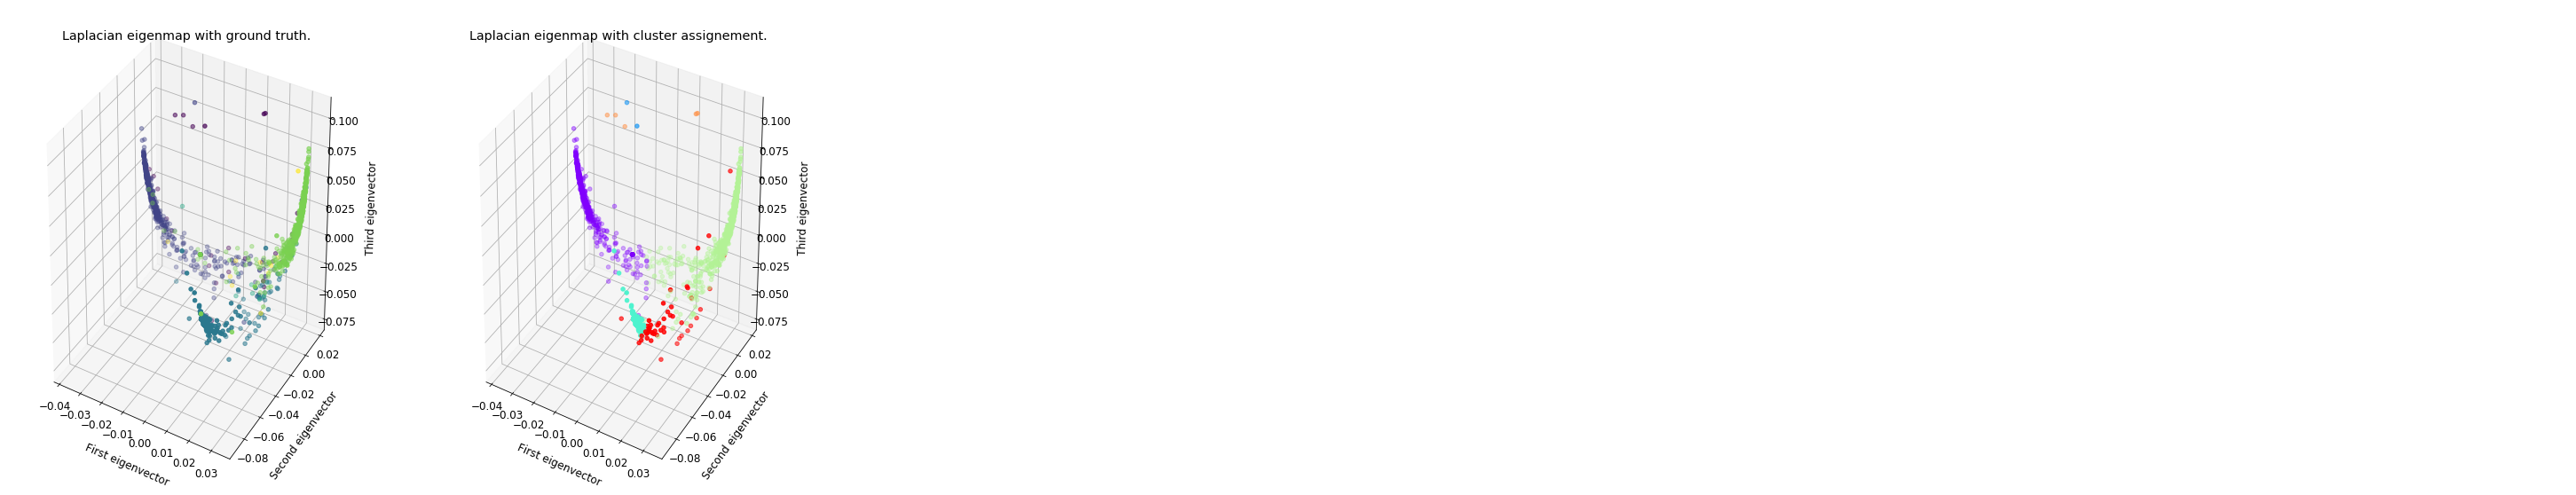

In [12]:
clus = clustering_label(np.dot(features,projection_matrix),'cosine',np.reshape(gt,len(gt)),'norm',6,'sc',1)

#### Section 3.3: The machine learning approach
As the clustering is not perfect, we decided to go to a pure machine learning approach. Two different types of classifier are trained and compared. 

In [13]:
df_features = pd.DataFrame(features)
target = pd.DataFrame(data = labels)
target_dummy = pd.get_dummies(target)
target_dummy.head()

,0_Arson,0_Bombing,0_Kidnapping,0_NBCR_Attack,0_Weapon_Attack,0_k
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [14]:
seed = 1
# Split the data into train and test
features_train, features_test, target_train, target_test = train_test_split(df_features, target_dummy, test_size=0.3, random_state=seed)

In [15]:
# Define a function to visulualize graphically the confusion matrix
# Note optional parameter for normalization; apply normalization by setting `normalize=True`

def plot_confusion_matrix(name, cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=[10,10])
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.savefig(name,bbox_inches = 'tight')

##### 3.3.1 Super Vector Machine classification

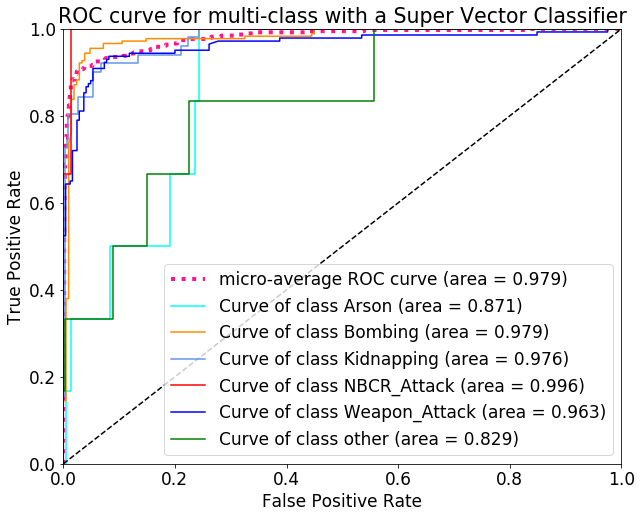

CPU times: user 32.7 s, sys: 191 ms, total: 32.9 s
Wall time: 33.2 s


In [16]:
%%time

X = df_features
y = target_dummy

n_classes = y.shape[1]


X_train = features_train
y_train = target_train
X_test = features_test
y_test = target_test


model_to_set = OneVsRestClassifier(SVC(probability=True, gamma='scale'))

parameters = {
    "estimator__C": [5,10,100,500,1000],
    "estimator__kernel": ["rbf",'linear']
}

classifier = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring ='f1_samples', cv = 3)

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 17})
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','blue','green'])
classes = ['Arson', 'Bombing', 'Kidnapping', 'NBCR_Attack', 'Weapon_Attack', 'other']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='Curve of class {0} (area = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class with a Super Vector Classifier')
plt.legend(loc="lower right")
plt.savefig('SVC.png', bbox_inches = 'tight')
plt.show()

In [17]:
print (classifier.best_score_)
print (classifier.best_params_)
print (classifier.best_estimator_)

0.8504604051565379
{'estimator__C': 10, 'estimator__kernel': 'rbf'}
OneVsRestClassifier(estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)


In [18]:
roc_auc_score(y_test, y_score, average = 'weighted')

0.9688060260189006

In [19]:
# model F1 score for X_test   
F1 = classifier.score(X_test, y_test) 
F1

0.8745704467353952

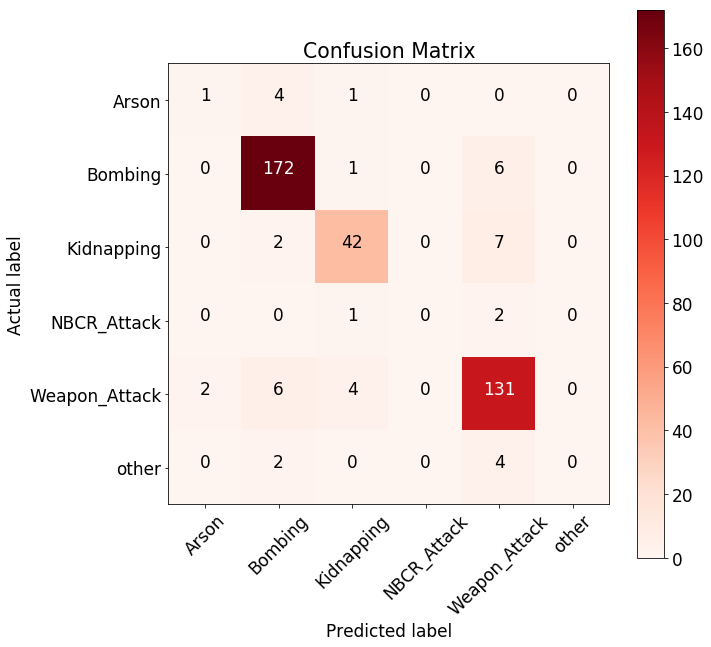

In [20]:
# creating a confusion matrix 
cm = confusion_matrix(y_test.values.argmax(axis=1), y_score.argmax(axis=1))
classes = ['Arson', 'Bombing', 'Kidnapping', 'NBCR_Attack', 'Weapon_Attack', 'other']
plot_confusion_matrix('confSVC',cm, classes, normalize=False)

###### 3.3.2 Gradient Boosting Tree classification

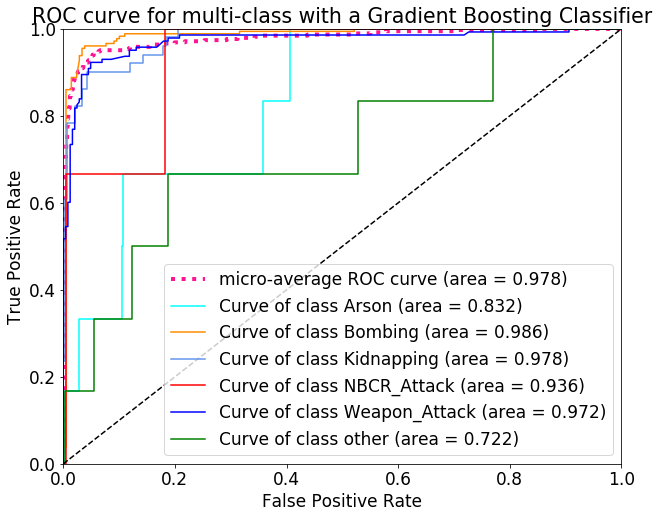

CPU times: user 1min 51s, sys: 712 ms, total: 1min 51s
Wall time: 1min 53s


In [21]:
%%time

X = df_features
y = target_dummy

n_classes = y.shape[1]

X_train = features_train
y_train = target_train
X_test = features_test
y_test = target_test

model_to_set = OneVsRestClassifier(GradientBoostingClassifier())

parameters = {
    "estimator__n_estimators": [int(i) for i in np.linspace(10.0, 300.0, 20)]
}

classifier = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring ='f1_samples', cv = 3)

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.values.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 17})
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','blue','green'])
classes = ['Arson', 'Bombing', 'Kidnapping', 'NBCR_Attack', 'Weapon_Attack', 'other']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label='Curve of class {0} (area = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class with a Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.savefig('GradientBoostingClassifier.png',bbox_inches = 'tight')
plt.show()

In [22]:
print (classifier.best_score_)
print (classifier.best_params_)
print (classifier.best_estimator_)

0.8559852670349909
{'estimator__n_estimators': 208}
OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          n_jobs=None)


In [23]:
roc_auc_score(y_test, y_score, average = 'weighted')

0.9731113888612758

In [24]:
# model F1 score for X_test   
F1 = classifier.score(X_test, y_test) 
F1

0.8728522336769758

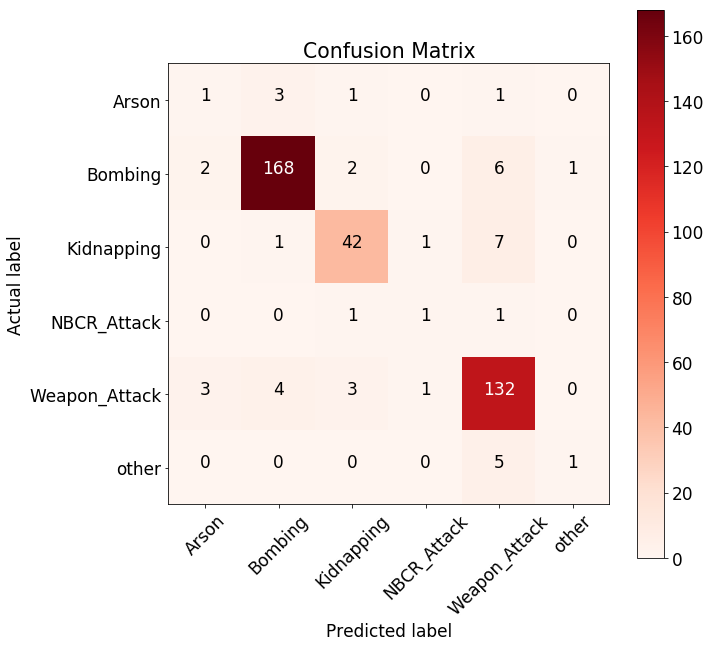

In [25]:
# creating a confusion matrix 
cm = confusion_matrix(y_test.values.argmax(axis=1), y_score.argmax(axis=1))
classes = ['Arson', 'Bombing', 'Kidnapping', 'NBCR_Attack', 'Weapon_Attack', 'other']
plot_confusion_matrix('confGradient.png',cm, classes, normalize=False)